In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
import imp
import time

In [314]:
from sklearn.decomposition import PCA

In [315]:
from sklearn.preprocessing import StandardScaler

In [316]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

### Create AnnData object and attach the metadata for interferon dataset

This dataset was used for the demuxlet paper, https://www.nature.com/articles/nbt.4042

In [317]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/'

In [6]:
metadata = pd.read_csv(data_path + 'GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [7]:
ctrl_adata = sc.read_10x_mtx(data_path + 'ctrl_mtx/')
stim_adata = sc.read_10x_mtx(data_path + 'stim_mtx/')

In [8]:
both_barcodes = list(set(ctrl_adata.obs.index) & set(stim_adata.obs.index))
stim_adata.obs.index = [bc + '1' if bc in both_barcodes else bc for bc in stim_adata.obs.index.tolist()]

In [9]:
combined_X = sp.sparse.vstack([ctrl_adata.X, stim_adata.X])
combined_bc = ctrl_adata.obs.index.tolist() + stim_adata.obs.index.tolist()

In [10]:
adata = sc.AnnData(combined_X)
adata.obs.index = combined_bc
adata.var = ctrl_adata.var
adata.obs = adata.obs.join(metadata, how='left')
adata.obs['ind'] = adata.obs['ind'].astype('category')
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.obsm['X_tsne'] = adata.obs[['tsne1', 'tsne2']].values
adata.write(data_path + 'interferon.h5ad')

... storing 'stim' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


### Filter for singlets

In [11]:
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()

In [318]:
adata.shape

(24673, 1654)

### Perform some basic filtering

In [13]:
sc.pp.filter_genes(adata, min_cells=50)

In [14]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[(adata.obs['n_counts'] > 10), :].copy()

In [15]:
sc.pp.filter_genes_dispersion(adata, min_mean=0.03, max_mean=100, min_disp=0.1)

In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

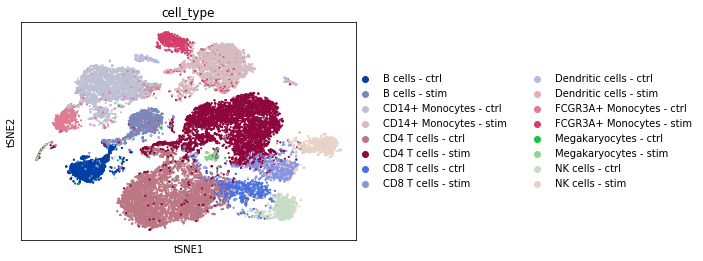

In [17]:
sc.pl.tsne(adata, color='cell_type')

In [18]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1654


### Total UMI count distribution for each cell type

In [19]:
total_umi_content = {}
for cell_type in adata.obs.cell_type.drop_duplicates().values:
    total_umi_content[cell_type] = adata.X[(adata.obs.cell_type == cell_type).values, :].sum(axis=1)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-pack

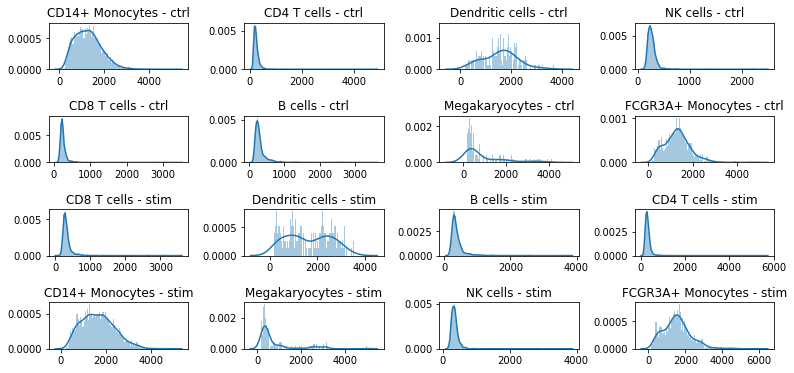

In [20]:
plt.figure(figsize=(13, 6))
plt.subplots_adjust(hspace=1, wspace=0.4)
idx = 1
for cell_type, total_umi_dist in total_umi_content.items():
    
    plt.subplot(4, 4, idx)
    sns.distplot(total_umi_dist, bins=100)
    plt.title(cell_type)
    idx +=1
# plt.subplot(4, 4, idx)
# sns.distplot(adata.X.sum(axis=1), bins=100);
# plt.title('All cells')

### Create an estimator

In [21]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [22]:
estimator = simplesc.SingleCellEstimator(adata, p=0.1, group_label='cell_type')

### Get some estimates for each cell type

In [23]:
estimator.compute_observed_statistics(group='CD4 T cells - ctrl')
estimator.compute_observed_statistics(group='CD4 T cells - stim')

In [24]:
estimator.compute_params(group='CD4 T cells - ctrl')
estimator.compute_params(group='CD4 T cells - stim')

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:71: RuntimeWarning: divide by zero encountered in log
  np.log(np.ones(self.anndata.shape[1])*self.p) - \
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:74: RuntimeWarning: invalid value encountered in true_divide
  (1-self.p) / self.observed_mus[group] + 1)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:74: RuntimeWarning: divide by zero encountered in true_divide
  (1-self.p) / self.observed_mus[group] + 1)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:80: RuntimeWarning: invalid value encountered in true_divide
  (1-self.p) / self.observed_mus[group] + 1)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:80: RuntimeWarning: divide by zero encountered in true_divide
  (1-self.p) / self.observed_mus[group] + 1)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:88: RuntimeWarning: inva

### Differential expression between IFN stim vs unstim CD4 T cells

In [319]:
t_stat, dof, pvals = estimator.differential_expression('CD4 T cells - ctrl', 'CD4 T cells - stim')
bayes = estimator.differential_expression_bayes('CD4 T cells - stim', 'CD4 T cells - ctrl')

In [320]:
np.argsort(pvals)[:5]

array([  0, 285, 708, 278, 277])

In [321]:
print(adata.var.index.values[np.argsort(t_stat)[:40]])

['CYP27A1' 'IFIT1' 'CDC42EP2' 'IFIT3' 'LY6E' 'IFIT2' 'LAMP3' 'CMPK2'
 'RSAD2' 'ISG15' 'IFI44L' 'CCL8' 'CXCL10' 'MT2A' 'OAS3' 'IL1RN' 'ISG20'
 'SAMD9L' 'CXCL11' 'TNFSF10' 'HERC5' 'IFI35' 'TGM1' 'GBP1' 'NEXN' 'TRIM22'
 'TARBP1' 'RTP4' 'DDX58' 'IFITM3' 'ETV7' 'PARP9' 'OAS2' 'MX2' 'IFIH1'
 'DDX60L' 'ZBP1' 'LGALS9' 'SPATS2L' 'SAMD9']


In [322]:
print(adata.var.index.values[np.argsort(bayes)[::-1][:40]])

['IFIT1' 'IFIT3' 'LY6E' 'IFIT2' 'LAMP3' 'CMPK2' 'RSAD2' 'ISG15' 'IFI44L'
 'CCL8' 'CXCL10' 'MT2A' 'OAS3' 'IL1RN' 'ISG20' 'SAMD9L' 'CXCL11' 'TNFSF10'
 'HERC5' 'IFI35' 'TGM1' 'GBP1' 'NEXN' 'TRIM22' 'TARBP1' 'RTP4' 'DDX58'
 'IFITM3' 'ETV7' 'PARP9' 'OAS2' 'MX2' 'IFIH1' 'DDX60L' 'ZBP1' 'LGALS9'
 'SPATS2L' 'SAMD9' 'APOBEC3B' 'FBXO6']


### Differential variance between IFN stim vs unstim CD4 T cells

In [323]:
probs, bayes_variance = estimator.differential_variance_bayes('CD4 T cells - stim', 'CD4 T cells - ctrl')

In [324]:
bayes_variance[np.argsort(bayes_variance)[::-1][:30]]

array([1.63242649, 1.52644621, 1.26566641, 1.23119965, 1.21027812,
       1.19647504, 1.17961392, 1.0375643 , 1.02553406, 1.0204757 ,
       0.9126336 , 0.90257693, 0.88797093, 0.87556792, 0.87532328,
       0.86401206, 0.82953668, 0.81905985, 0.8003737 , 0.78281977,
       0.77648188, 0.76931632, 0.74548004, 0.74200692, 0.70036532,
       0.69698982, 0.68635396, 0.66215836, 0.66195479, 0.65529062])

In [325]:
print(adata.var.index.values[np.argsort(bayes_variance)[::-1][:30]])

['IFIT3' 'IFIT1' 'IFIT2' 'RSAD2' 'ISG15' 'CMPK2' 'IFI44L' 'LY6E' 'PARP9'
 'HERC5' 'SAMD9' 'IFIH1' 'OASL' 'MX2' 'SPATS2L' 'OAS3' 'SAMD9L' 'OAS2'
 'FBXO6' 'LAMP3' 'C19orf66' 'TRIM22' 'HERC6' 'DDX60L' 'SNX6' 'MT2A' 'RTP4'
 'WDR61' 'LGALS9' 'TREX1']


In [326]:
only_variance_change = np.absolute(bayes < 1) * (bayes_variance > 0.5)

In [327]:
only_variance_change.sum()

10

In [328]:
np.where(only_variance_change)[0]

array([ 153,  205,  274,  483,  731,  816,  922, 1284, 1311, 1406])

In [329]:
adata.var.index.values[only_variance_change]

array(['ZNF281', 'USP34', 'C2orf47', 'MRPS30', 'SMS', 'CPNE3', 'UBE2D1',
       'WDR61', 'NDUFAB1', 'MRPS23'], dtype=object)

In [330]:
idx = 1284

In [331]:
print(estimator.estimated_mus['CD4 T cells - stim'][idx], estimator.estimated_mus['CD4 T cells - ctrl'][idx])

-1.0512728037788768 -2.022950515247667


In [332]:
print(estimator.estimated_sigmas['CD4 T cells - stim'][idx, idx], estimator.estimated_sigmas['CD4 T cells - ctrl'][idx, idx])

1.1394551238375927 3.251946117301296


In [404]:
data_ctrl = stats.norm.rvs(
    loc=estimator.estimated_mus['CD4 T cells - stim'][idx],
    scale=estimator.estimated_sigmas['CD4 T cells - stim'][idx, idx],
    size=10000)
data_stim = stats.norm.rvs(
    loc=estimator.estimated_mus['CD4 T cells - ctrl'][idx],
    scale=estimator.estimated_sigmas['CD4 T cells - ctrl'][idx, idx],
    size=10000)

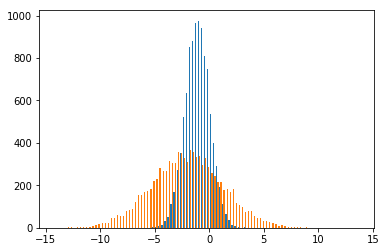

In [405]:
plt.hist([data_ctrl, data_stim], bins=100);

### Get lupus dataset patient metadata

In [339]:
data_path + 'cluestime1.csv'

'/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/interferon_data/cluestime1.csv'

In [340]:
patient_metadata = pd.read_csv(data_path + 'cluestime1.csv', sep='\t')

In [349]:
adata.obs.ind.value_counts()

1015    5090
1488    4580
1256    4134
1016    3358
1244    3343
101     2024
1039    1102
107     1042
Name: ind, dtype: int64

In [352]:
set(adata.obs.ind) & set(patient_metadata.query('female != 1').subjectid.tolist())

set()

In [345]:
patient_metadata.female.value_counts()

1    297
0     37
Name: female, dtype: int64

In [343]:
patient_metadata.columns.tolist()

['subjectid',
 'female',
 'genderident',
 'age',
 'sledxyr',
 'slesxdx',
 'dxdrspecialty',
 'dxdroth_spec',
 'specialisttime',
 'sledrnow',
 'mainmdname',
 'mainmdhosp',
 'mainmdspecialty',
 'mainmdothspec',
 'mdfrequency',
 'sleflare',
 'flareseverity',
 'weightloss',
 'weightlossseverity',
 'fatigue',
 'fatigueseverity',
 'fevers',
 'feversseverity',
 'sores',
 'soresseverity',
 'rashcheek',
 'rashcheekseverity',
 'rashother',
 'rashotherspec',
 'rashotherseverity',
 'skinspots',
 'skinspotsseverity',
 'sunsick',
 'sunsickseverity',
 'bald',
 'baldseverity',
 'swollenglands',
 'swollenglandsseverity',
 'shortbreath',
 'shortbreathseverity',
 'chestpain',
 'chestpainseverity',
 'raynaud',
 'raynaudseverity',
 'stomachpain',
 'stomachpainseverity',
 'numbness',
 'numbnessseverity',
 'seizures3mo',
 'seizures3moseverity',
 'stroke',
 'forgetfulness',
 'forgetfulnessseverity',
 'depressedslaq',
 'depressedseverity',
 'headaches',
 'headachesseverity',
 'musclepain',
 'musclepainseverity'

### Investigate genes on X chromosome

In [333]:
adata.var['gene_name'] = adata.var.index.values

In [334]:
gene_metadata = pd.read_csv(data_path + '../misc/my_uscs_ids_symbols.map.bed', sep='\t', header=None)\
    .iloc[:, [5, 0]]\
    .copy()
gene_metadata.columns = ['gene_name', 'chr']
gene_metadata = gene_metadata.drop_duplicates(subset=['gene_name'])

In [335]:
adata.var.merge(gene_metadata, on='gene_name', how='inner').shape

(1639, 7)

In [336]:
adata.var['gene_name'] = adata.var.index.values
adata.var = adata.var.merge(gene_metadata, on='gene_name', how='left')
adata.var.index = adata.var.gene_name

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 


In [49]:
adata.var.head(5)

,gene_ids,n_cells,means,dispersions,dispersions_norm,gene_name,chr
gene_name,,,,,,,
HES4,ENSG00000188290,2316,0.182675,1.275783,4.575653,HES4,chr1
ISG15,ENSG00000187608,14816,3.013363,4.640787,1.000000,ISG15,chr1
TNFRSF18,ENSG00000186891,1185,0.065190,0.565670,1.588208,TNFRSF18,chr1
TNFRSF4,ENSG00000186827,1076,0.067958,1.010330,3.458893,TNFRSF4,chr1
NADK,ENSG00000008130,1309,0.064278,0.390851,0.852743,NADK,chr1


In [59]:
x_variances = np.diag(estimator.estimated_sigmas['CD4 T cells - stim'])[adata.var.chr == 'chrX']
x_variances = x_variances[x_variances > 0]
other_variances = np.diag(estimator.estimated_sigmas['CD4 T cells - stim'])[adata.var.chr != 'chrX']
other_variances = other_variances[other_variances > 0]

In [63]:
x_means = np.diag(estimator.estimated_mus['CD4 T cells - stim'])[adata.var.chr == 'chrX']
x_means = x_means[x_means > 0]
other_means = np.diag(estimator.estimated_mus['CD4 T cells - stim'])[adata.var.chr != 'chrX']
other_means = other_means[other_means > 0]

In [64]:
x_means.mean()

0.5606898744668815

In [65]:
other_means.mean()

0.8183816374946165

In [1]:
x_means

NameError: name 'x_means' is not defined

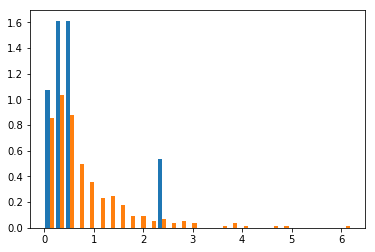

In [66]:
plt.hist([x_means, other_means], bins=30, density=True);

In [68]:
stats.ks_2samp(other_means, x_means)

Ks_2sampResult(statistic=0.3464534645346453, pvalue=0.19638262892409714)

### Simulations

In [89]:
data_x = stats.norm.rvs(loc=5, scale=2, size=100000)
data_y = stats.norm.rvs(loc=1, scale=1, size=100000)

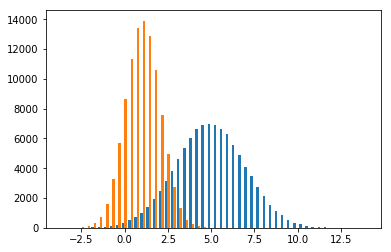

In [91]:
plt.hist([data_x, data_y], bins=50);

In [96]:
count = 0
num_trial = 100000
for trial in range(num_trial):
    x = np.random.choice(data_x)
    y = np.random.choice(data_y)
    
    if x > y:
        count += 1


In [97]:
count/num_trial

0.96343

In [98]:
stats.norm.sf(0, loc=4, scale=np.sqrt(1+4))

0.9631808649398487

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


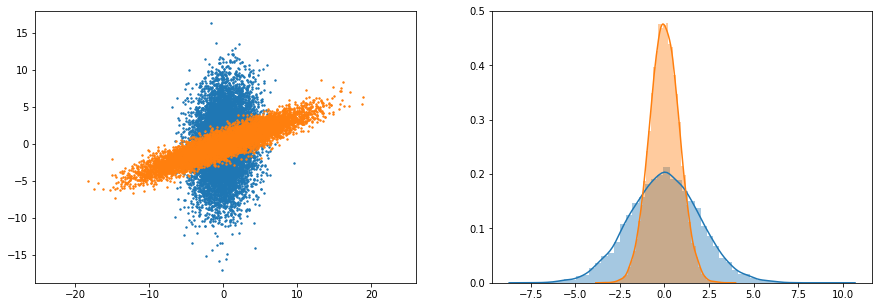

In [299]:
cov_term_1 = 1
data_1 = stats.multivariate_normal.rvs(mean=[0, 0], cov=[[4, cov_term_1], [cov_term_1, 16]], size=10000)

cov_term_2 = 2*5*0.9
data_2 = stats.multivariate_normal.rvs(mean=[0, 0], cov=[[25, cov_term_2], [cov_term_2, 4]], size=10000)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_1[:,0], data_1[:, 1], s=2)
plt.scatter(data_2[:,0], data_2[:, 1], s=2)

plt.axis('equal')
plt.subplot(1, 2, 2)
X_pca_1 = PCA().fit_transform(data_1)
sns.distplot(X_pca_1[:, 1], bins=50);
X_pca_2 = PCA().fit_transform(data_2)
sns.distplot(X_pca_2[:, 1], bins=50);

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


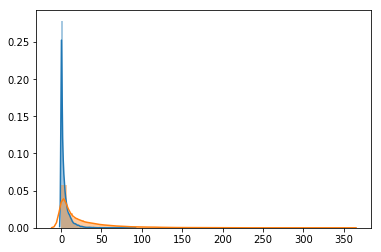

In [311]:
sns.distplot(product_1, bins=50);
sns.distplot(product_2, bins=50);

In [ ]:
data_1

In [302]:
p/(1-p)

2.6363636363636362

In [312]:
product_1 = data_1[:, 0]*data_1[:, 0]
product_2 = data_2[:, 0]*data_2[:, 0]
p = ((product_2-product_1) > 0).mean()
print(2*(np.log(p)-np.log(1-p)))

2.2726036201938005


In [286]:
num_trial = 100000
count = 0
for trial in range(num_trial):
    
    idx1 = np.random.choice(10000)
    idx2 = np.random.choice(10000)
    
    if data_2[idx2, 0]*data_2[idx2, 1] > data_1[idx1, 0]*data_1[idx1, 1]:
        count += 1

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


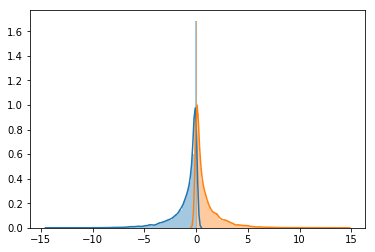

In [226]:
sns.distplot(data_1[:, 0]*data_1[:, 1], bins=100);
sns.distplot(data_2[:, 0]*data_2[:, 1], bins=100);

### Differential correlation

In [431]:
dz, dc_pvals = estimator.differential_correlation('CD4 T cells - stim', 'CD4 T cells - ctrl')

/anaconda3/envs/scvi/lib/python3.6/site-packages/statsmodels/stats/moment_helpers.py:190: RuntimeWarning: divide by zero encountered in true_divide
  corr = cov / np.outer(std_, std_)
/anaconda3/envs/scvi/lib/python3.6/site-packages/statsmodels/stats/moment_helpers.py:190: RuntimeWarning: invalid value encountered in true_divide
  corr = cov / np.outer(std_, std_)
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:244: RuntimeWarning: invalid value encountered in log
  
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:244: RuntimeWarning: divide by zero encountered in log
  
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:245: RuntimeWarning: invalid value encountered in log
  print('Not yet implemented!')
/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:245: RuntimeWarning: divide by zero encountered in log
  print('Not yet implemented!')
/Users/mincheolkim/Github/scrna-parameter-estimat

In [434]:
np.nan_to_num(dz).max()

1.7976931348623157e+308

In [423]:
(dz > 0)

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


matrix([[False, False, False, ..., False, False,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False,  True, ...,  True, False,  True],
        ...,
        [False,  True,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])

In [425]:
2*stats.norm.sf(dz)[:5, -5:] * (dz > 0)[:5, -5:]# + 2*stats.norm.cdf(dz) * (dz <= 0)

/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


matrix([[0., 0., 4., 0., 4.],
        [0., 0., 0., 0., 0.],
        [4., 4., 4., 2., 6.],
        [4., 4., 4., 2., 6.],
        [2., 2., 5., 2., 5.]])

In [417]:
3.12989873e3

3129.89873

In [419]:
(dz > 0)

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


matrix([[False, False, False, ..., False, False,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False,  True, ...,  True, False,  True],
        ...,
        [False,  True,  True, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])

In [418]:
stats.norm.sf(dz)

/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


array([[       nan, 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        ,        nan, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ...,        nan, 1.        ,
        1.        ],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.59926466],
       [0.        , 0.        , 0.        , ..., 1.        , 0.59926466,
               nan]])

In [415]:
dz

matrix([[            nan, -3.12989873e+03, -1.74597864e+04, ...,
         -9.06608997e+03, -7.77321740e+03,  4.34296779e+03],
        [-3.12989873e+03,             nan, -8.82092575e+02, ...,
          1.84708416e+03,  2.19409071e+03,  5.34426620e+02],
        [-1.74597864e+04, -8.82092575e+02,  1.11986139e+04, ...,
          5.67533507e+03, -7.25094149e+03,  1.10243760e+04],
        ...,
        [-9.06608997e+03,  1.84708416e+03,  5.67533507e+03, ...,
                     nan, -1.65202552e+04, -4.30986915e+03],
        [-7.77321740e+03,  2.19409071e+03, -7.25094149e+03, ...,
         -1.65202552e+04,            -inf, -2.51444225e-01],
        [ 4.34296779e+03,  5.34426620e+02,  1.10243760e+04, ...,
         -4.30986915e+03, -2.51444225e-01,             nan]])

In [412]:
dc_pvals

matrix([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])

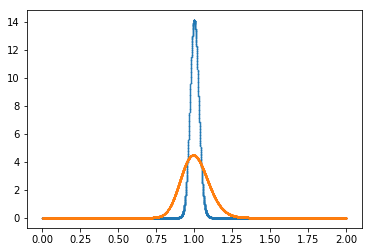

In [110]:
plt.scatter(x, y1, s=0.3)
plt.scatter(x, y2, s=0.3)

In [96]:
y

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       1.09516954e-127, 1.00749965e-127, 9.26845282e-128])

In [387]:
stats.f.sf([1.1, 1.2], 5000, 5000)

array([3.77319505e-04, 5.92417156e-11])

In [ ]:
np.where(adata.var.index.values == 'IRF2')[0][0]

In [ ]:
adata.obs.head(5)

In [ ]:
#i = np.where(adata.var.index.values == 'IRF8')[0][0]
for i in np.argsort(bayes)[::-1][:50]:
#     print(estimator.estimated_mus['CD4 T cells - ctrl'][i], estimator.estimated_mus['CD4 T cells - stim'][i])
#     print(adata.var.index.values[i])
#     print(bayes[i])
    plt.figure()
    plt.hist([
        adata.X[(adata.obs.cell_type == 'CD4 T cells - ctrl').values, :][:, i].todense().A1, 
        adata.X[(adata.obs.cell_type == 'CD4 T cells - stim').values, :][:, i].todense().A1
    ], bins=50);
    plt.title(adata.var.index.values[i])
    #plt.ylim(0, 100)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


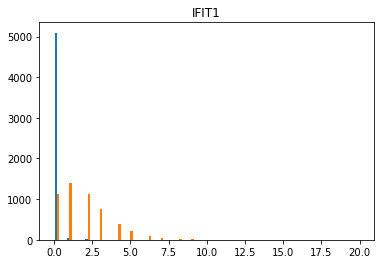

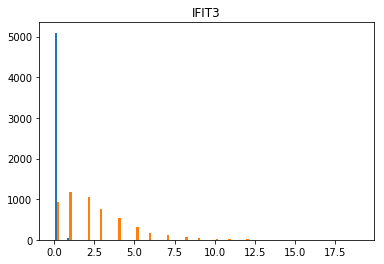

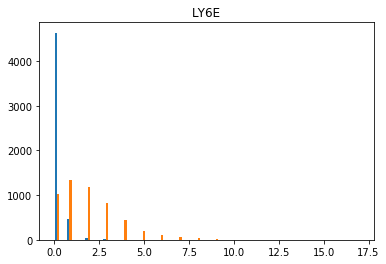

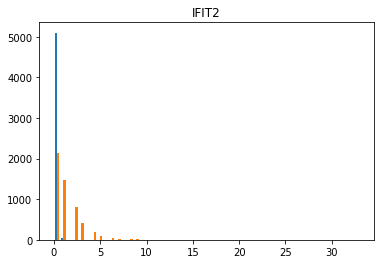

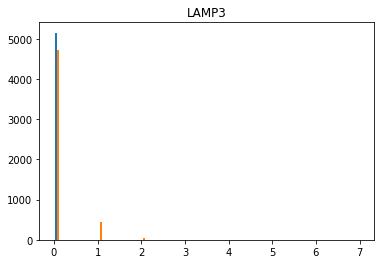

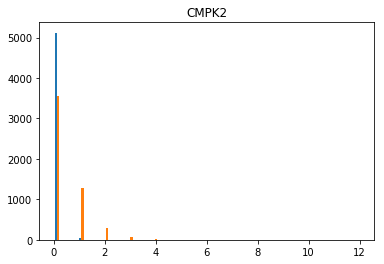

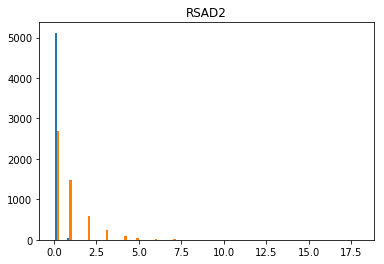

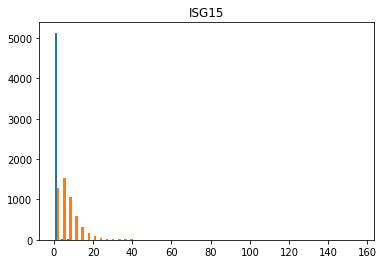

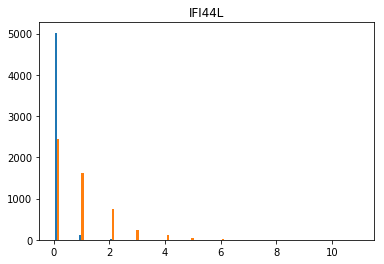

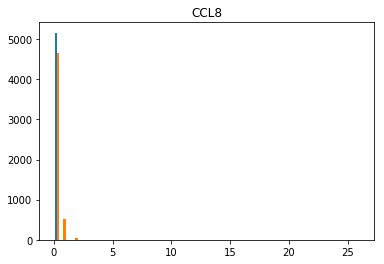

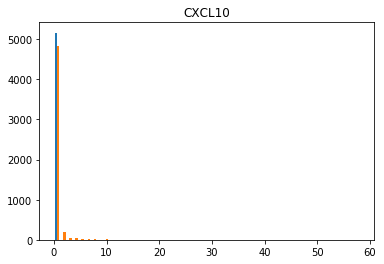

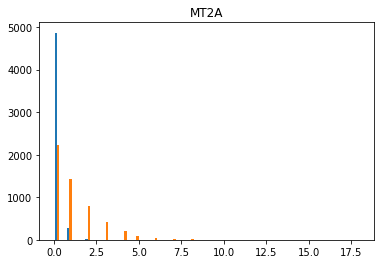

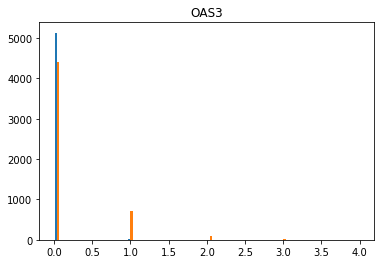

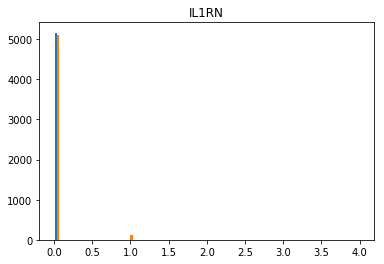

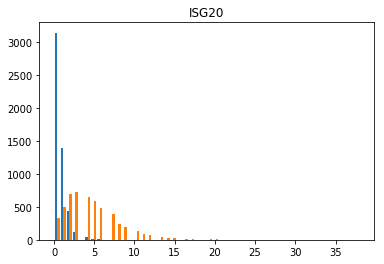

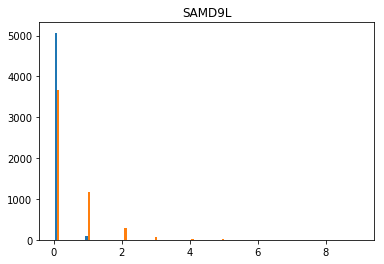

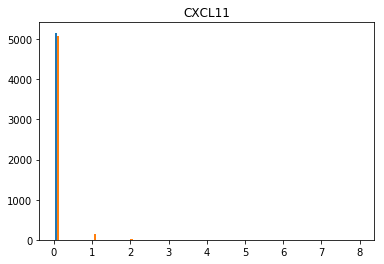

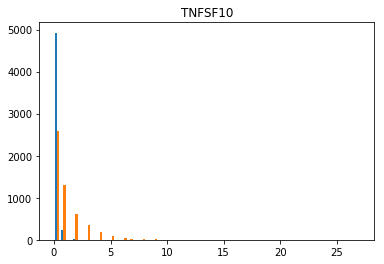

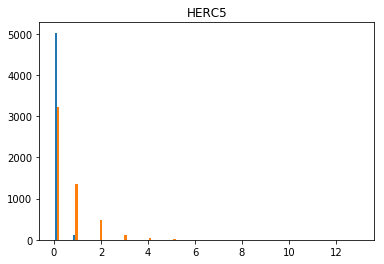

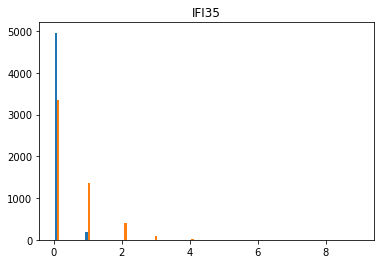

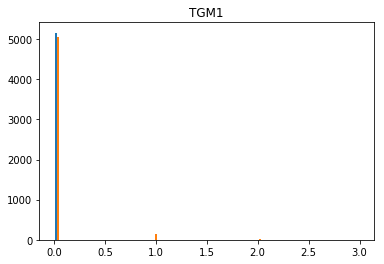

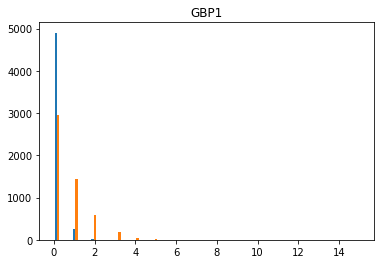

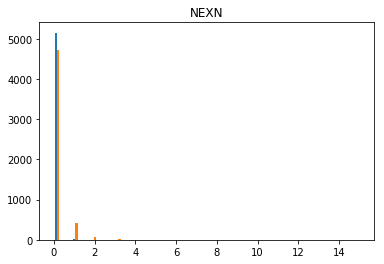

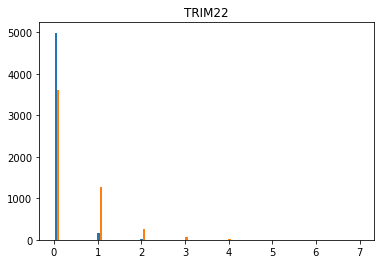

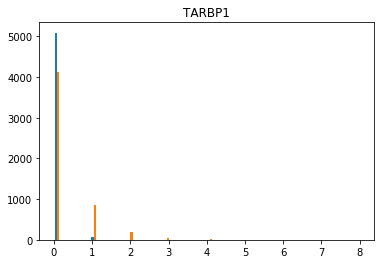

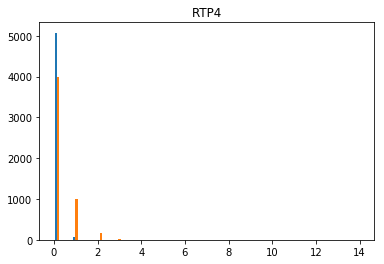

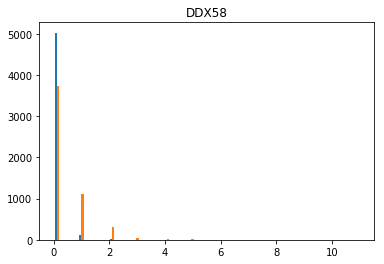

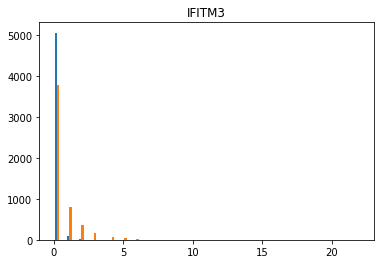

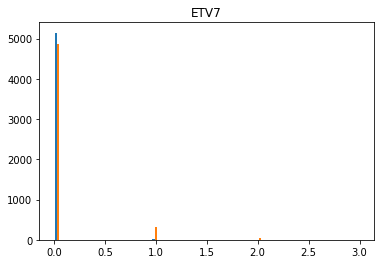

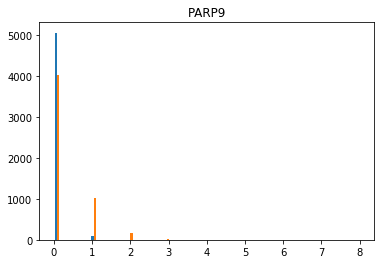

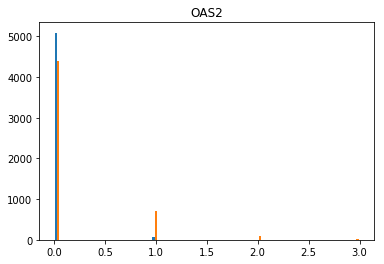

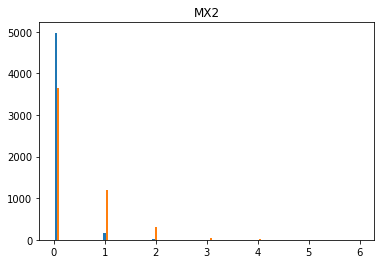

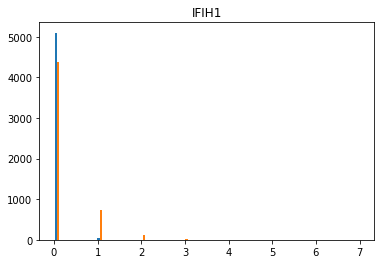

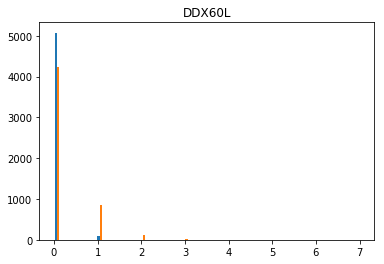

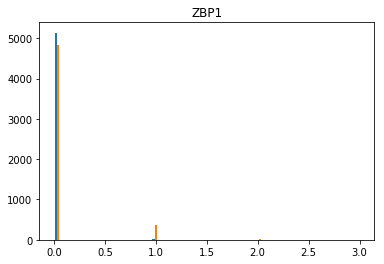

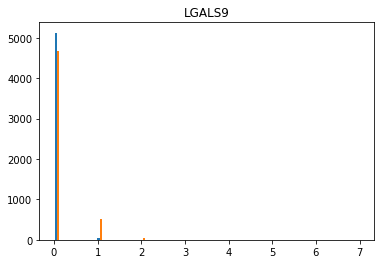

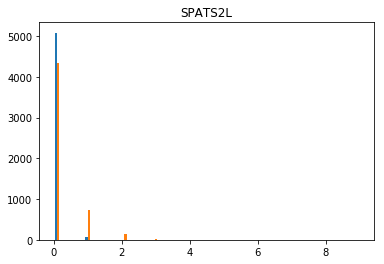

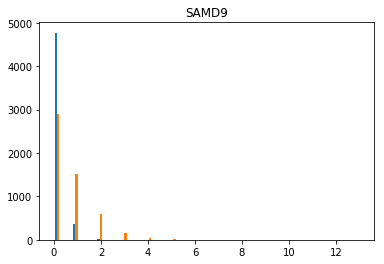

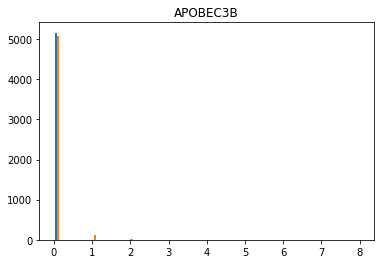

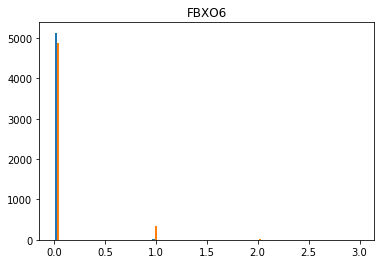

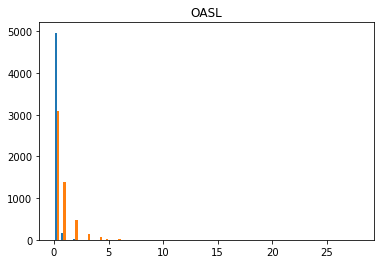

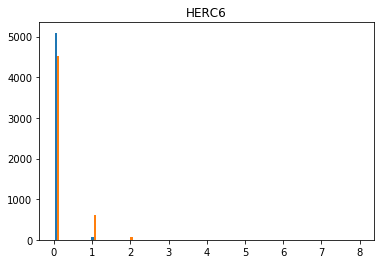

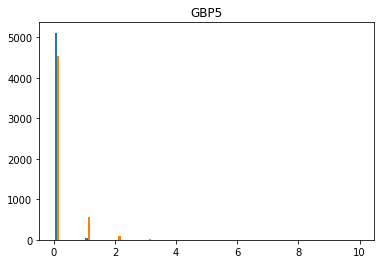

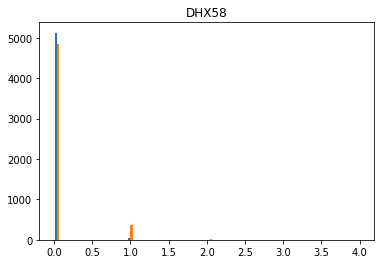

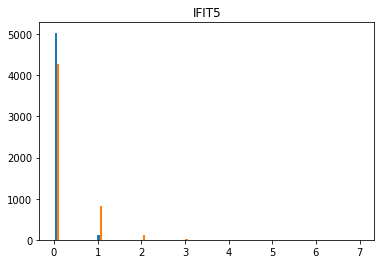

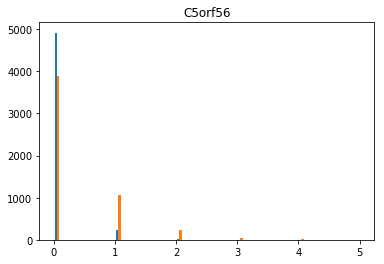

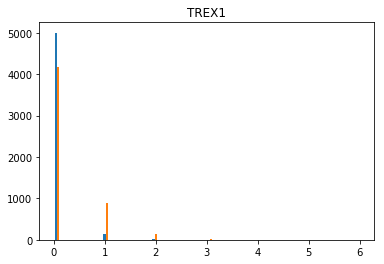

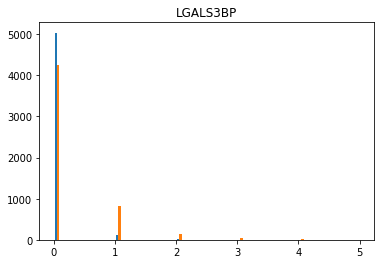

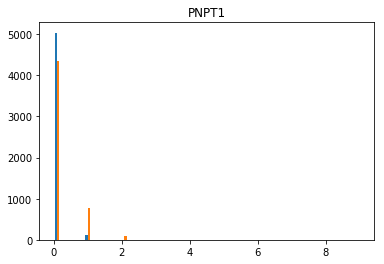

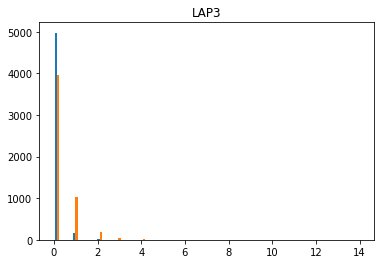

In [727]:
#i = np.where(adata.var.index.values == 'IRF8')[0][0]
for i in np.argsort(bayes)[::-1][:50]:
#     print(estimator.estimated_mus['CD4 T cells - ctrl'][i], estimator.estimated_mus['CD4 T cells - stim'][i])
#     print(adata.var.index.values[i])
#     print(bayes[i])
    plt.figure()
    plt.hist([
        adata.X[(adata.obs.cell_type == 'CD4 T cells - ctrl').values, :][:, i].todense().A1, 
        adata.X[(adata.obs.cell_type == 'CD4 T cells - stim').values, :][:, i].todense().A1
    ], bins=50);
    plt.title(adata.var.index.values[i])
    #plt.ylim(0, 100)

In [641]:
i = 1150
print(adata.var.index.values[i])
temp = stats.norm.sf(
    0, 
    loc=estimator.estimated_mus['CD4 T cells - stim'][i] - estimator.estimated_mus['CD4 T cells - ctrl'][i],
    scale=np.sqrt(estimator.estimated_sigmas['CD4 T cells - stim'][i, i] + estimator.estimated_sigmas['CD4 T cells - ctrl'][i, i]))
print(np.log(temp / (1-temp)))

OASL
3.1405390166239426


In [642]:
stats.norm.sf(0, [1, 2], [3, 4])

array([0.63055866, 0.69146246])

In [609]:
estimator.estimated_mus['CD4 T cells - ctrl']

array([-4.06518168, -0.93267039, -2.01768329, ..., -1.25763718,
       -2.40939819,  0.4927766 ])

In [610]:
estimator.estimated_mus['CD4 T cells - stim']

array([-2.41432003,  4.05684749, -2.39286174, ..., -1.51933193,
       -3.72291001,  0.55878008])

In [611]:
estimator.estimated_sigmas['CD4 T cells - ctrl']

matrix([[ 3.82645018,  2.85010115,  1.84550062, ...,  0.65754239,
          0.        , -0.63861906],
        [ 2.85010115,  3.62490726,  0.59558981, ...,  0.17963752,
         -0.2783697 , -0.03920723],
        [ 1.84550062,  0.59558981,  2.42760036, ...,  0.4545786 ,
         -0.02175777, -0.9752409 ],
        ...,
        [ 0.65754239,  0.17963752,  0.4545786 , ...,  1.50867677,
          0.08314159, -0.23946158],
        [ 0.        , -0.2783697 , -0.02175777, ...,  0.08314159,
          2.16615931,  0.28517028],
        [-0.63861906, -0.03920723, -0.9752409 , ..., -0.23946158,
          0.28517028,  0.86668731]])

In [732]:
estimator.estimated_sigmas['CD4 T cells - stim']

matrix([[ 2.99490930e+00,  8.97507156e-01,  4.71265409e-01, ...,
          5.74107560e-04, -6.72554163e-01, -3.45708460e-01],
        [ 8.97507156e-01,  5.15870666e-01,  2.13129471e-01, ...,
          1.26822572e-01, -3.75554456e-02, -3.51799388e-03],
        [ 4.71265409e-01,  2.13129471e-01,  2.89373705e+00, ...,
          8.90015877e-01, -6.43414722e-01, -6.58433632e-01],
        ...,
        [ 5.74107560e-04,  1.26822572e-01,  8.90015877e-01, ...,
          1.75380986e+00, -9.47107105e-01, -3.86541600e-01],
        [-6.72554163e-01, -3.75554456e-02, -6.43414722e-01, ...,
         -9.47107105e-01,  2.71106348e+00,  3.00567978e-01],
        [-3.45708460e-01, -3.51799388e-03, -6.58433632e-01, ...,
         -3.86541600e-01,  3.00567978e-01,  7.69344968e-01]])

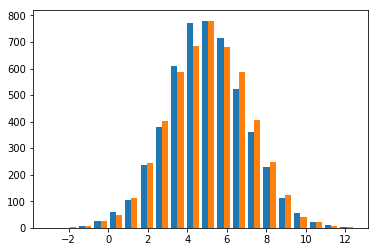

In [754]:
plt.hist([np.random.normal(5, 2, 5000), np.random.normal(5.01, 2, 5000)], bins=20);


In [1]:
plt.hist(bayes, bins=20)
plt.title('Bayes factors')

NameError: name 'plt' is not defined

Text(0.5,1,'P values')

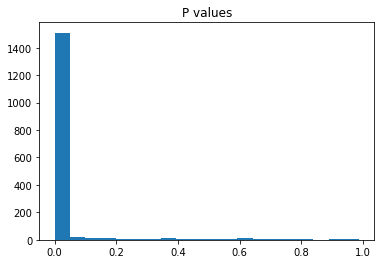

In [758]:
plt.hist(pvals, bins=20)
plt.title('P values')

In [755]:
stats.ttest_ind(np.random.normal(5, 2, 10000), np.random.normal(5.1, 2, 10000))

Ttest_indResult(statistic=-2.8913730211113644, pvalue=0.0038397563701668747)

In [608]:
stats.norm.sf(0, loc=6, scale=np.sqrt(4+9)) / (1-stats.norm.sf(0, loc=6, scale=np.sqrt(4+9)))

19.81331581125408

In [591]:
estimator.estimated_mus['CD 4 T cells - ctrl']

KeyError: 'CD 4 T cells - ctrl'

In [530]:
pvals[:5]

array([0.00000000e+00, 0.00000000e+00, 1.50320569e-31, 7.17673440e-10,
       0.00000000e+00])

In [532]:
pvals[285]

0.0

In [548]:
most_significant_genes = adata.var.index.values[np.argsort(pvals)[:20]]

In [550]:
np.argsort(pvals)[:20]

array([   0,  285,  708,  278,  277,  712,  275,  274, 1150,  713, 1475,
        717,  718, 1145, 1144,  259,  258, 1146,  288,  290])

In [563]:
adata.var.index.values[274]

'C2orf47'

In [549]:
most_significant_genes

array(['HES4', 'CYP27A1', 'TMEM140', 'CASP8', 'CFLAR', 'PARP12',
       'SPATS2L', 'C2orf47', 'OASL', 'CLEC5A', 'HM13', 'ZNF775', 'GIMAP4',
       'OAS2', 'OAS3', 'GCA', 'IFIH1', 'SDS', 'TUBA4A', 'PID1'],
      dtype=object)

In [555]:
estimator.estimated_sigmas['CD4 T cells - stim'][285, 285]

0.0

In [584]:
estimator.estimated_mus['CD4 T cells - ctrl'][1475]

-1.1295734990473867

In [585]:
estimator.estimated_mus['CD4 T cells - stim'][1475]

-0.15201300214160024

### Reconstruct total UMI distribution

In [110]:
generated_transcriptome = estimator.generate_transcriptome('NK cells')

/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py:108: RuntimeWarning: covariance is not positive-semidefinite.
  size=N)


In [111]:
total_num_counts = generated_transcriptome.sum(axis=1)

In [112]:
estimator.estimated_sigmas['NK cells'][i, i]

1.3610712102827656

In [113]:
estimator.estimated_mus['NK cells'][i]

-0.05914493677654875

In [339]:
i = -7

In [340]:
data = adata.X[(adata.obs.cell == 'NK cells').values, :][:, i].todense().A1

In [341]:
reconstructed_counts = np.random.binomial(
    np.round(
        stats.lognorm.rvs(
        s=np.sqrt(estimator.estimated_sigmas['NK cells'][i, i]),
        scale=np.exp(estimator.estimated_mus['NK cells'][i]), 
        size=data.shape[0]) ).astype(np.int64), p)

reconstructed_counts_2 = np.random.binomial(
    np.round(np.exp(
        stats.norm.rvs(
        scale=np.sqrt(estimator.estimated_sigmas['NK cells'][i, i]),
        loc=estimator.estimated_mus['NK cells'][i], 
        size=data.shape[0]) )).astype(np.int64), 0.1)

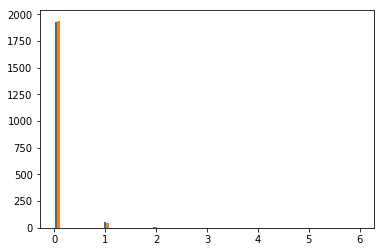

In [342]:
plt.hist([data, reconstructed_counts_2], bins=50);
#plt.ylim(0, 10)

In [345]:
stats.t.sf([1, 1], df=[2, 2])

array([0.21132487, 0.21132487])

In [343]:
generated_transcriptome.shape

(1993, 1646)

In [73]:
data = adata.X[(adata.obs.cell == 'NK cells').values, :][:, i].todense()

In [229]:
generated_transcriptome.max(axis=1)

array([    585066,    2071003,      12913, ..., 7372532685,       5875,
            20773])

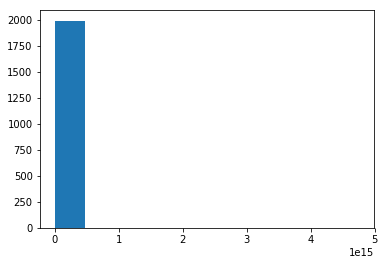

In [230]:
plt.hist(total_num_counts);

In [ ]:
s = 

In [316]:
np.exp(0)

1.0

In [330]:
np.exp(-100)

3.720075976020836e-44

In [331]:
np.exp(0)

1.0

In [332]:
np.exp(-100)

3.720075976020836e-44

In [ ]:
np.

In [328]:
temp = stats.lognorm.rvs(s=1e-100, scale=1, size=1000)

In [329]:
temp

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [303]:
np.exp(0)

1.0

### Grab ISG genes

In [14]:
cd4_adata_norm = cd4_adata.copy()
sc.pp.filter_genes(cd4_adata_norm, min_cells=5)
sc.pp.normalize_per_cell(cd4_adata_norm, counts_per_cell_after=1e4)
sc.pp.log1p(cd4_adata_norm)

In [15]:
sc.pp.filter_genes_dispersion(cd4_adata_norm, min_mean=0.0125, max_mean=3, min_disp=0.3)
sc.pp.scale(cd4_adata_norm, max_value=10)

### Get a list of ISGs from the Interferome search result

In [18]:
search_result = pd.read_csv(data_path + 'interferome_t_cells.txt', header=16, index_col=False, sep='\t')
search_result['Gene Name'] = search_result['Gene Name'].str.upper()
search_result['mag_fold_change'] = np.absolute(search_result['Fold Change'])
search_result = search_result[search_result['Inteferome Type'] == 'I']
search_result = search_result\
    .sort_values('mag_fold_change', ascending=False)\
    .drop_duplicates('Gene Name')
search_result = search_result[['Fold Change', 'Treatment Time', 'Gene Name', 'Description', 'mag_fold_change']]

In [19]:
isg_candidates = pd.concat([
    search_result[search_result['Fold Change'] > 0].head(30),
    search_result[search_result['Fold Change'] < 0].head(30)])
isg_genes = isg_candidates['Gene Name'].tolist()

In [20]:
#isg_candidates.to_csv(data_path + 'isg_candidates.csv')

In [21]:
len(isg_genes)

50

In [22]:
isg_genes[:5]

['IFI44L', 'IFIT3', 'IFIT1', 'IFI6', 'RSAD2']

### Get a list of IRFs just from the name for now

In [23]:
irf_genes = [gene for gene in cd4_adata.var.index if gene[:3] == 'IRF']

In [24]:
len(irf_genes)

12

In [25]:
irf_genes

['IRF6',
 'IRF2BP2',
 'IRF2',
 'IRF1',
 'IRF4',
 'IRF5',
 'IRF7',
 'IRF9',
 'IRF2BPL',
 'IRF8',
 'IRF2BP1',
 'IRF3']

In [26]:
[gene for gene in cd4_adata_norm.var.index if gene[:3] == 'IRF']

['IRF1', 'IRF7', 'IRF2BPL', 'IRF8']

### Check some correlations in single cell data

In [129]:
cd4_adata_norm = cd4_adata.copy()
sc.pp.normalize_per_cell(cd4_adata_norm, counts_per_cell_after=1e4)
sc.pp.log1p(cd4_adata_norm)
sc.pp.scale(cd4_adata_norm, max_value=10)

/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1142: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(var)
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1148: RuntimeWarning: divide by zero encountered in true_divide
  X /= scale
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1148: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/anaconda3/envs/scvi/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:965: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


In [130]:
#cd4_adata_norm.write(data_path + 'interferon.cd4.norm.h5ad')

In [131]:
cxcl10_exp = cd4_adata_norm[:, 'CXCL10'].X.reshape(-1)
ccl5_exp = cd4_adata_norm[:, 'CCL5'].X.reshape(-1)
ccl3_exp = cd4_adata_norm[:, 'CCL3'].X.reshape(-1)
irf7_exp = cd4_adata_norm[:, 'IRF7'].X.reshape(-1)
irf4_exp = cd4_adata_norm[:, 'IRF4'].X.reshape(-1)
OAS1_exp = cd4_adata_norm[:, 'OAS1'].X.reshape(-1)

(0.33326358, 6.728614120857142e-268)


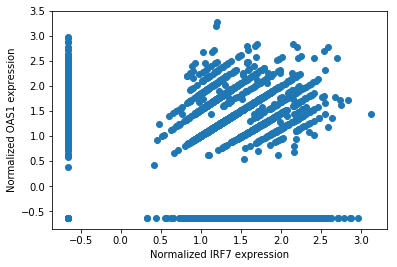

In [133]:
plt.scatter(irf7_exp, OAS1_exp)
plt.xlabel('Normalized IRF7 expression')
plt.ylabel('Normalized OAS1 expression')

print(stats.pearsonr(irf7_exp, OAS1_exp))

(-0.005310951, 0.5883249335774889)


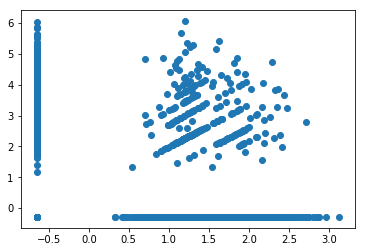

In [832]:
plt.scatter(irf7_exp, ccl5_exp)
print(stats.pearsonr(irf7_exp, ccl5_exp))

(0.19816679, 1.7202134814153068e-92)


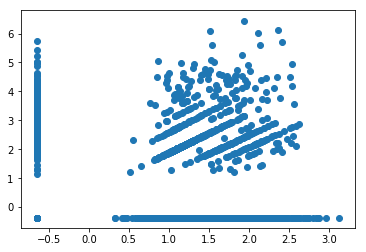

In [708]:
plt.scatter(irf7_exp, cxcl10_exp)
print(stats.pearsonr(irf7_exp, cxcl10))

(0.028776474, 0.0033533840334995704)


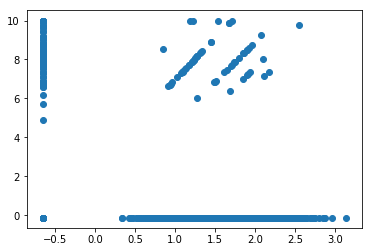

In [709]:
plt.scatter(irf7_exp, ccl3_exp)
print(stats.pearsonr(irf7_exp, ccl3))